# Final Project 
## Analysis of Subway usage of Seoul using based on signal processing 

### How things go:
+ Obtain temporal Seoul subway usage data
+ Extract features using fourier transformation (or wavelet transfomr)
+ Cluster based on similarity
+ Analyze the result based on urban context

### 1. Obtain temporal Seoul subway usage data
+ Data is retrieved from [http://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do]

In [11]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
raw_path = './Rawdata/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv'

raw_df = pd.read_csv(raw_path)
sample_df = raw_df[raw_df['사용월'] >= 202101]

In [3]:
start_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(4, 24)]
end_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(0, 4)]

times = start_times + end_times
in_times = [i + '승차인원' for i in times]
out_times = [i + '하차인원' for i in times]

col_names = ['사용월', '호선명','지하철역']
in_cols = col_names + in_times
out_cols = col_names + out_times
in_df = sample_df[in_cols]
out_df = sample_df[out_cols]

in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2423 entries, 0 to 2422
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           2423 non-null   int64 
 1   호선명           2423 non-null   object
 2   지하철역          2423 non-null   object
 3   04시-05시 승차인원  2423 non-null   int64 
 4   05시-06시 승차인원  2423 non-null   int64 
 5   06시-07시 승차인원  2423 non-null   int64 
 6   07시-08시 승차인원  2423 non-null   int64 
 7   08시-09시 승차인원  2423 non-null   int64 
 8   09시-10시 승차인원  2423 non-null   int64 
 9   10시-11시 승차인원  2423 non-null   int64 
 10  11시-12시 승차인원  2423 non-null   int64 
 11  12시-13시 승차인원  2423 non-null   int64 
 12  13시-14시 승차인원  2423 non-null   int64 
 13  14시-15시 승차인원  2423 non-null   int64 
 14  15시-16시 승차인원  2423 non-null   int64 
 15  16시-17시 승차인원  2423 non-null   int64 
 16  17시-18시 승차인원  2423 non-null   int64 
 17  18시-19시 승차인원  2423 non-null   int64 
 18  19시-20시 승차인원  2423 non-null   int64 
 19  20시-21

In [63]:
# Create pivot table dataframe
in_pivot = pd.pivot_table(in_df, index = ['지하철역', '사용월'])
in_pivot_df = in_pivot.stack().to_frame('influx')
in_pivot_df

influx
지하철역      사용월                        
4.19민주묘지  202101 00시-01시 승차인원     0.0
                 01시-02시 승차인원     0.0
                 02시-03시 승차인원     0.0
                 03시-04시 승차인원     0.0
                 04시-05시 승차인원     0.0
...                               ...
흑석(중앙대입구) 202104 19시-20시 승차인원  8400.0
                 20시-21시 승차인원  7125.0
                 21시-22시 승차인원  7241.0
                 22시-23시 승차인원  7515.0
                 23시-24시 승차인원  1498.0

[49776 rows x 1 columns]

In [65]:
# Reorganize multiindex of pivot table
row_to_col = in_pivot_df.unstack(level = -3) # Move the outermost row index to column
no_influx = row_to_col.droplevel(0, axis = 1) # Remove redundant column name "influx"
no_influx.index = no_influx.index.set_levels(no_influx.index.levels[0].astype(str), level = 0 ) # Change date int type to str for merging
no_influx.index = no_influx.index.map('_'.join) # Merge multi index into one index
in_df_cols = no_influx
print(in_df_cols)
#in_df_cols = no_influx.droplevel(0) # Remove the innermost row index "사용월"

지하철역                 4.19민주묘지      가능     가락시장  가산디지털단지       가양     가오리  \
202101_00시-01시 승차인원       0.0    42.0      3.0     36.0      0.0     3.0   
202101_01시-02시 승차인원       0.0     0.0      0.0      0.5      0.0     0.0   
202101_02시-03시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202101_03시-04시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202101_04시-05시 승차인원       0.0   266.0     14.0    682.0     46.0     3.0   
...                       ...     ...      ...      ...      ...     ...   
202104_19시-20시 승차인원    2922.0  5589.0  11833.5  93583.0  19210.0  2792.0   
202104_20시-21시 승차인원    2115.0  4348.0   9157.5  49761.0  13011.0  1944.0   
202104_21시-22시 승차인원    1626.0  3706.0   9730.0  44481.0  11657.0  1523.0   
202104_22시-23시 승차인원    1069.0  3118.0   8087.0  28099.0   8836.0  1213.0   
202104_23시-24시 승차인원     282.0   757.0   1257.5   4600.5   1624.0   313.0   

지하철역                     가좌     가천대      가평      간석  ...       화곡  \
202101_00시-01시 승차인

In [323]:
sample_cols = in_df_cols.sample(n = 7, axis = 1)
print(sample_cols)

지하철역                     초지  서울대입구(관악구청)       망원      방학     왕십리(성동구청)  \
202101_00시-01시 승차인원    21.0          3.0      0.0    65.0     18.000000   
202101_01시-02시 승차인원     0.0          0.0      0.0     0.0      0.333333   
202101_02시-03시 승차인원     0.0          0.0      0.0     0.0      0.000000   
202101_03시-04시 승차인원     0.0          0.0      0.0     0.0      0.000000   
202101_04시-05시 승차인원   171.0       3494.0      1.0   345.0    414.333333   
...                     ...          ...      ...     ...           ...   
202104_19시-20시 승차인원  5349.0      51454.0  24490.0  9172.0  17002.333333   
202104_20시-21시 승차인원  3422.0      42056.0  19410.0  6480.0  15711.333333   
202104_21시-22시 승차인원  2967.0      49865.0  21508.0  5331.0  19781.333333   
202104_22시-23시 승차인원  1950.0      45059.0  18167.0  4267.0  19900.666667   
202104_23시-24시 승차인원   514.0       9026.0   3985.0  1086.0   3275.333333   

지하철역                  정부과천청사      신포  
202101_00시-01시 승차인원      2.0     4.0  
202101_01시-02시 승차인원  

[0, 24, 48, 72]


<Figure size 432x288 with 0 Axes>

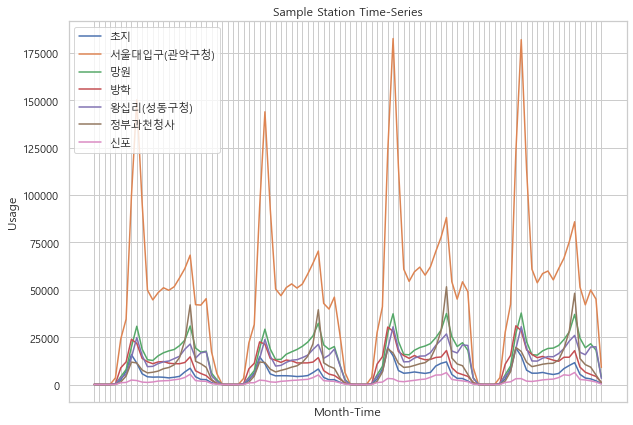

In [490]:
#Visualize the time-usage graph

plt.clf()
xi = [i*24 for i in range(4)]
print(xi)
ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Usage')
plt.plot(sample_cols)
plt.title('Sample Station Time-Series')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(sample_cols.columns)
plt.show()
fig.savefig('./final_fig/fig_0.png')

<Figure size 432x288 with 0 Axes>

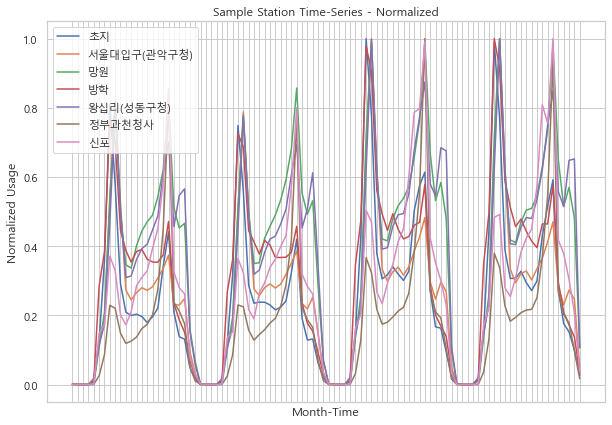

In [335]:
def norm_col(df, col):
    return col/df[col].max()
norm_cols = pd.DataFrame()
for col in sample_cols:
    norm_cols[col] = sample_cols[col] / sample_cols[col].max()

#norm_cols = sample_cols.apply(norm_col, axis = 1)
plt.clf()

ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(norm_cols)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(norm_cols.columns, loc = 2)
plt.show()
fig.savefig('./final_fig/fig_1.png')

### 2. Extract features using fourier transformation (or wavelet transfomr)

In [404]:
# Import Wavelet and decompose
import pywt
w = pywt.Wavelet('db4')
wavelet_cols = pd.DataFrame()
for k, v in enumerate(norm_cols):
    cA, cD = pywt.dwt(norm_cols[v], wavelet = w)
    cA10 = sorted(cA, reverse = True)
    cD10 = sorted(cD, reverse = True)
    ext_cA = cA10[:5]
    ext_cD = cD10[:5]
    wavelet_cols[v] = [i for i in zip(ext_cA, ext_cD)]
wavelet_cols


,초지,서울대입구(관악구청),망원,방학,왕십리(성동구청),정부과천청사,신포
0,"(1.2540326230951542, 0.08401681902909328)","(1.1007979497660163, 0.16723596455327389)","(1.2371325957069468, 0.16630484185814426)","(1.318848057530706, 0.11209971823443574)","(1.183631984676916, 0.20214101487282551)","(1.0762562679270422, 0.34014260916177685)","(1.3163069071249585, 0.22449720991555897)"
1,"(1.242763946083138, 0.07968008500815096)","(1.1007250277257499, 0.16606144033829012)","(1.2072452992500635, 0.15761091799230173)","(1.2963137264868778, 0.10512569769215298)","(1.1437723123215473, 0.20057027683097597)","(1.0285774816308186, 0.2943844687840438)","(1.290168751769556, 0.22314563321245606)"
2,"(0.9894248277293132, 0.07906492600560978)","(0.8997252698267729, 0.14316492721642263)","(1.1307758915541946, 0.15131661235503058)","(1.015241544528568, 0.09729815321317423)","(1.0577310700746094, 0.18694063535477926)","(0.8586782505024189, 0.27287248127025826)","(1.009512047741607, 0.19646025241283574)"
3,"(0.9216482290047969, 0.07486780848790973)","(0.8505126016834028, 0.1428795194898918)","(1.124524052310817, 0.14751224424792814)","(0.9666095988877947, 0.08333505573089788)","(1.0549406950083446, 0.17692128182726158)","(0.8133092391727512, 0.2649384071945059)","(0.9634946495553219, 0.19568821922845575)"
4,"(0.8825826444407531, 0.07376858666794968)","(0.83810438276004, 0.08138882758979811)","(1.080859197898314, 0.14308260462268874)","(0.8770894948980552, 0.05724814382753153)","(1.0376856902570952, 0.11719688654608401)","(0.5326026084747284, 0.02237203644333209)","(0.8435631516208713, 0.10708376362392916)"


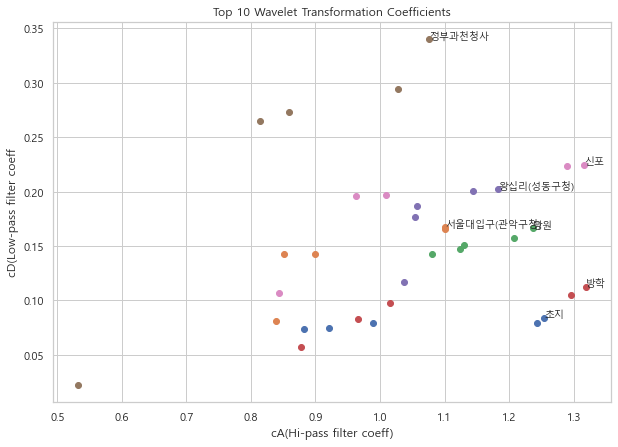

In [405]:
#import seaborn as sns
plt.rc('font', family = 'Malgun Gothic')

ax, fig1 = ax, plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Top 10 Wavelet Transformation Coefficients')
#plt.legend(wavelet_cols.columns)
for v in wavelet_cols:
    temp = list(wavelet_cols[v])
    cA, cD = zip(*temp)
    plt.scatter(x = cA, y = cD)
    plt.annotate(v, (max(cA), max(cD)), size = 10)
plt.show()
fig1.savefig('./Final_fig/fig_2.png')

### 3.Cluster based on similarity

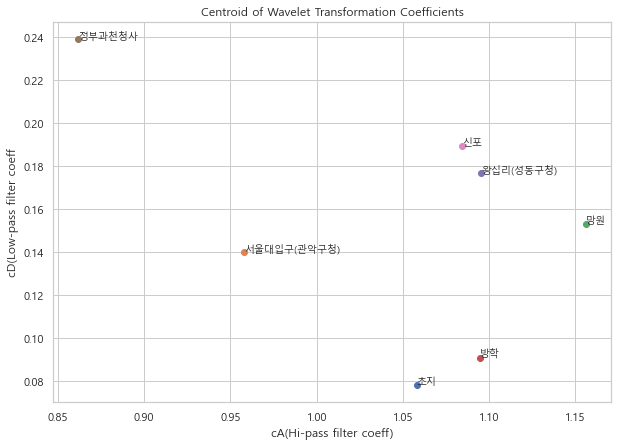

In [406]:
def get_cent(col):
    n = len(col)
    temp = list(col)
    x, y = zip(*temp)
    cent_x = sum(x)/n
    cent_y = sum(y)/n
    return (cent_x, cent_y)
cent_cols = pd.DataFrame()

ax, fig2 = ax, plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Centroid of Wavelet Transformation Coefficients')
for v in wavelet_cols:
    cent_cols[v] = get_cent(wavelet_cols[v])
    plt.scatter(cent_cols[v].iloc[0], cent_cols[v].iloc[1])
    plt.annotate(v, (cent_cols[v].iloc[0], cent_cols[v].iloc[1]), size = 10)
#plt.scatter(cent_cols.iloc[0], cent_cols.iloc[1])
plt.show()
fig2.savefig('./Final_fig/fig_3.png')

In [407]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import numpy as np
np_cols = cent_cols.T.to_numpy()
num_cluster = 4
'''
kmeans = KMeans(n_clusters = num_cluster, random_state = 0).fit(np_cols)
labeled = pd.DataFrame(kmeans.labels_, index = cent_cols.columns, columns = ['label'])
DBSCAN_ = DBSCAN(min_samples = num_cluster).fit(np_cols)
labeled = pd.DataFrame(DBSCAN_.labels_, index = cent_cols.columns, columns = ['label'])
'''
BotUp = AgglomerativeClustering(n_clusters = num_cluster).fit(np_cols)
labeled = pd.DataFrame(BotUp.labels_, index = cent_cols.columns, columns = ['label'])
#cent_cols.T
labeled_cols = cent_cols.append(pd.DataFrame(labeled).T).T
labeled_cols.columns = ['cA', 'cD', 'label']
labeled_cols

,cA,cD,label
초지,1.058090,0.078280,2.0
서울대입구(관악구청),0.957973,0.140146,3.0
망원,1.156107,0.153165,0.0
방학,1.094820,0.091021,2.0
왕십리(성동구청),1.095552,0.176754,0.0
정부과천청사,0.861885,0.238942,1.0
신포,1.084609,0.189375,0.0


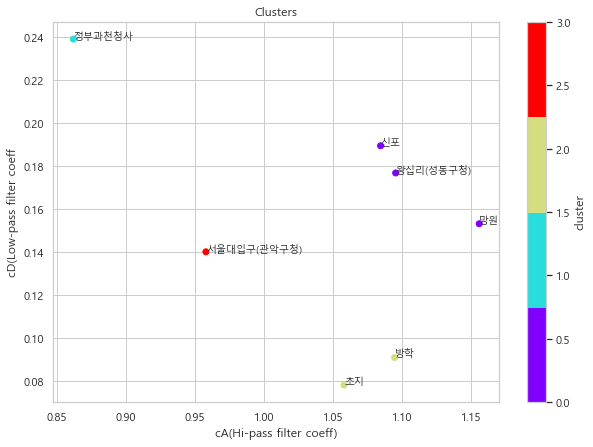

In [422]:
plt.rc('font', family = 'Malgun Gothic')
ax, fig3 = ax, plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Clusters')
plt.scatter(x = 'cA', y = 'cD',data = labeled_cols, c = 'label', cmap = plt.cm.get_cmap('rainbow', num_cluster))
for i, name in enumerate(labeled_cols.index):
    plt.annotate(name, (labeled_cols.loc[name]['cA'], labeled_cols.loc[name]['cD']), size = 10)
plt.colorbar(label = 'cluster')
plt.show()
fig3.savefig('./Final_fig/fig_4.png')

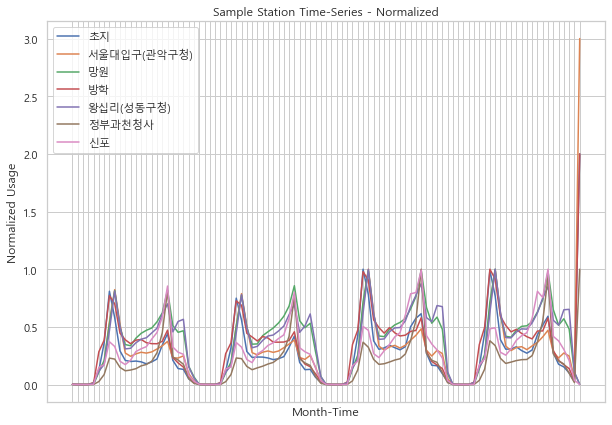

In [432]:
#plt.clf()
'''
ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(norm_cols)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(norm_cols.columns, loc = 2)
plt.show()
fig.savefig('./final_fig/fig_1.png')
'''

labeled_norm = norm_cols.append(pd.DataFrame(labeled).T)
labeled_norm.tail()

ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(labeled_norm)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
plt.legend(labeled_norm.columns, loc = 2)
plt.show()

{0: ['망원', '왕십리(성동구청)', '신포'], 1: ['정부과천청사'], 2: ['초지', '방학'], 3: ['서울대입구(관악구청)']}


<Figure size 432x288 with 0 Axes>

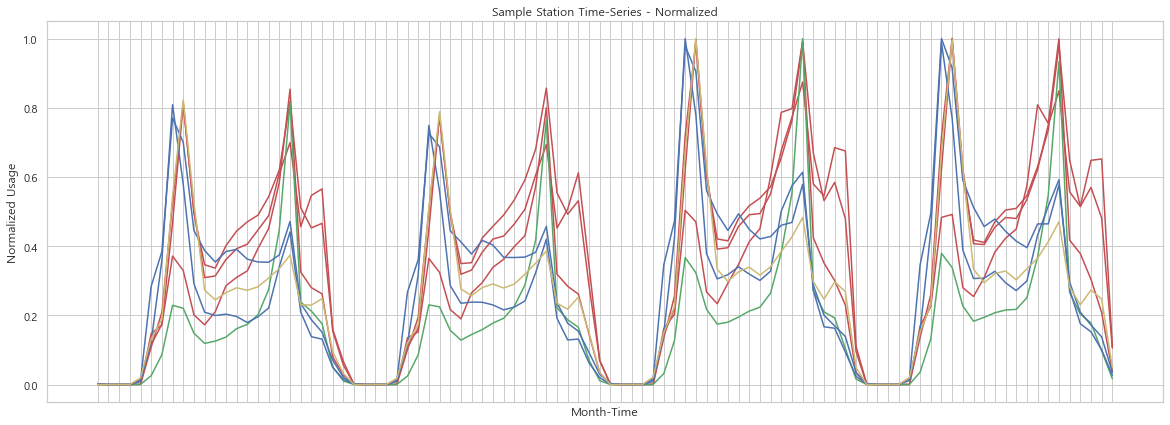

In [489]:
cluster_dict = {}
for i in range(num_cluster):
    test = labeled_cols.query('label == {}'.format(i)).index.tolist()
    cluster_dict[i] = test
print(cluster_dict)
plt.clf()
fig5, ax = plt.subplots(figsize = (20, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
c_list = [plt.cm.rainbow(i) for i in cluster_dict.keys()]
c_list2 = ['r','g','b','y']
for k, v in cluster_dict.items():
    ax.plot(norm_cols[v], color = c_list2[k])
plt.show()
fig5.savefig('./Final_fig/fig_5.png')